In [1]:
import pyprob
from pyprob import Model, InferenceEngine
from pyprob.distributions import Normal

import torch
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

# Define model

First, we define the model as a probabilistic program inheriting from `pyprob.Model`. Models inherit from `torch.nn.Module` and can be potentially trained with gradient-based optimization (not covered in this example).

The `forward` function can have any number and type of arguments as needed. 

**Important:** For running posterior inference inference compilation, it is expected that `forward` has an argument called `observation` with which the observations are given to the model.

In [2]:
# http://www.robots.ox.ac.uk/~fwood/assets/pdf/Wood-AISTATS-2014.pdf

class GaussianWithUnknownMean(Model):
    def __init__(self, prior_mean=1, prior_stddev=math.sqrt(5), likelihood_stddev=math.sqrt(2)):
        self.prior_mean = prior_mean
        self.prior_stddev = prior_stddev
        self.likelihood_stddev = likelihood_stddev
        super().__init__('Gaussian with unknown mean')

    def forward(self, observation=[]):
        mu = pyprob.sample(Normal(self.prior_mean, self.prior_stddev))
        likelihood = Normal(mu, self.likelihood_stddev)
        for o in observation:
            pyprob.observe(likelihood, o)
        return mu
    
model = GaussianWithUnknownMean()

def correct_posterior(x):
    p = Normal(7.25, math.sqrt(1/1.2))
    return math.exp(p.log_prob(x))

# Test the prior

We inspect the prior distribution to see if it behaves in the way we intended. First we construct an `Empirical` distribution with forward samples from the model. 

Note: Any arguments, besides `samples`, given to `prior_distribution` will be forwarded to the model's `forward` function.

In [3]:
prior_dist = model.prior_distribution(num_traces=1000)

Time spent  | Time remain.| Progress             | Trace     | Traces/sec
0d:00:00:00 | 0d:00:00:00 | #################### | 1000/1000 | 1,254.85        


We can `sample` from the `Empirical` distribution.

In [4]:
print(prior_dist.sample())

Variable containing:
 2.0163
[torch.FloatTensor of size 1]



We can plot a histogram of samples from this Empirical distribution.

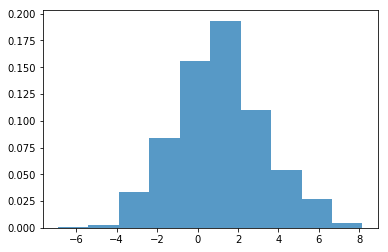

In [5]:
n, bins, patches = plt.hist([float(prior_dist.sample()) for i in range(1000)], normed=1, alpha=0.75)

# Posterior inference with lightweight Metropolis Hastings

For a given set of observations, we get an empirical posterior distribution using a lightweight Metropolis Hastings sampler.
See:
- Wingate, D., Stuhlmüller, A. and Goodman, N., 2011, June. Lightweight implementations of probabilistic programming languages via transformational compilation. In Proceedings of the Fourteenth International Conference on Artificial Intelligence and Statistics (pp. 770-778).

In [10]:
posterior_dist = model.posterior_distribution(num_traces=10000, 
                                              observation=[8,9], 
                                              inference_engine=InferenceEngine.LIGHTWEIGHT_METROPOLIS_HASTINGS)

Time spent  | Time remain.| Progress             | Trace       | Accepted|Smp reuse| Traces/sec


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.


0d:00:00:11 | 0d:00:00:00 | ###################- |  9254/10000 |   1.00% |   0.01% | 783.34       

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.


The following shows the sampled posterior with the correct posterior (orange curve).

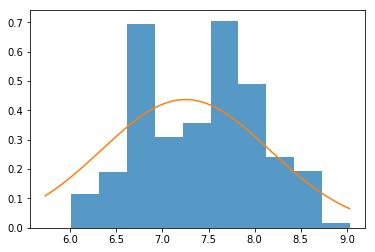

In [11]:
n, bins, patches = plt.hist([float(posterior_dist.sample()) for i in range(1000)], normed=1, alpha=0.75)
x = np.linspace(posterior_dist.min,posterior_dist.max,400)
plt.plot(x, np.vectorize(correct_posterior)(x))
plt.show()

# Posterior inference with importance sampling

For a given set of observations, we can get an empirical posterior distribution using importance sampling.

In [12]:
posterior_dist = model.posterior_distribution(num_traces=5000, 
                                              observation=[8,9],
                                              inference_engine=InferenceEngine.IMPORTANCE_SAMPLING)

Time spent  | Time remain.| Progress             | Trace     | Traces/sec


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.


0d:00:00:05 | 0d:00:00:00 | #################### | 5000/5000 | 898.87       


Regular importance sampling uses proposals from the prior distribution. We can see this by plotting the histogram of the posterior distribution without using the importance weights. As expected, this is the same with the prior distribution.

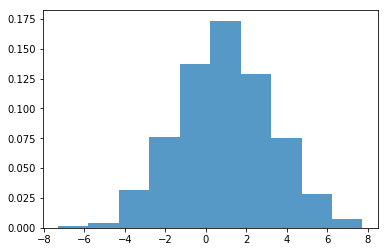

In [13]:
posterior_dist_unweighted = posterior_dist.unweighted()
n, bins, patches = plt.hist([float(posterior_dist_unweighted.sample()) for i in range(1000)], normed=1, alpha=0.75)

When we do use the weights, we end up with the correct posterior distribution. The following shows the sampled posterior with the correct posterior (orange curve).

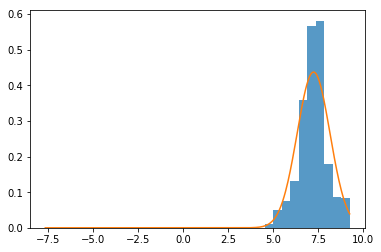

In [14]:
n, bins, patches = plt.hist([float(posterior_dist.sample()) for i in range(1000)], normed=1, alpha=0.75)
x = np.linspace(posterior_dist.min,posterior_dist.max,400)
plt.plot(x, np.vectorize(correct_posterior)(x))
plt.show()

In practice, it is advised to use methods of the `Empirical` posterior distribution instead of dealing with the weights directly, which ensures that the weights are used in the correct way.

For instance, we can get samples from the correct posterior, compute its mean and standard deviation, and evaluate expectations of a function under the distribution.

In [15]:
print(posterior_dist.sample())

Variable containing:
 7.4023
[torch.FloatTensor of size 1]



In [16]:
print(posterior_dist.mean)

Variable containing:
 7.2002
[torch.FloatTensor of size 1]



In [17]:
print(posterior_dist.stddev)

Variable containing:
 0.8218
[torch.FloatTensor of size 1]



In [18]:
print(posterior_dist.expectation(lambda x: torch.sin(x)))

Variable containing:
 0.5721
[torch.FloatTensor of size 1]



# Inference compilation

Inference compilation is a technique where a deep neural network is used for parameterizing the proposal distribution in importance sampling (https://arxiv.org/abs/1610.09900). This neural network, which we call inference network, is automatically generated and trained with data sampled from the model.

We can learn an inference network for our model.

In [19]:
model.learn_inference_network(observation=[0, 0], num_traces=10000)

Creating new inference network...
Polymorphing, new layers for address: 16/forward.mu_Normal_1
Train. time | Trace     | Init. loss| Min. loss | Curr. loss| T.since min | Traces/sec
0d:00:00:23 | 10,048    | +2.38e+00 | +1.43e+00 | +1.67e+00 | 0d:00:00:09 | 436.0                              


We now construct the posterior distribution using samples from inference compilation, using the trained inference network.

A much smaller number of samples are enough because the inference network provides good proposals based on the given observations. We can see that the proposal distribution given by the inference network is doing a job much better than the prior, by plotting the posterior samples without the importance weights, for a selection of observations.

Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:02 | 0d:00:00:00 | #################### | 500/500 | 185.95          


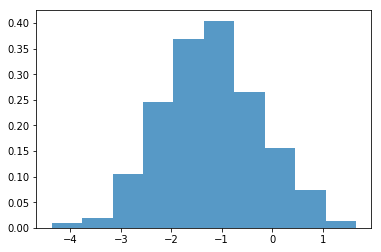

In [20]:
posterior_dist_unweighted = model.posterior_distribution(num_traces=500, 
                                                         inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK, 
                                                         observation=[-1,-2]).unweighted()
n, bins, patches = plt.hist([float(posterior_dist_unweighted.sample()) for i in range(1000)], normed=1, alpha=0.75)

Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:02 | 0d:00:00:00 | #################### | 500/500 | 187.22          


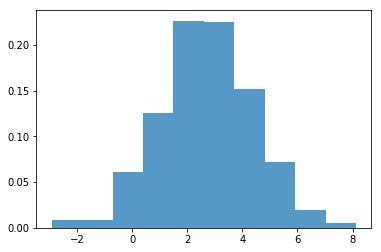

In [21]:
posterior_dist_unweighted = model.posterior_distribution(num_traces=500, 
                                                         inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK, 
                                                         observation=[2,3]).unweighted()
n, bins, patches = plt.hist([float(posterior_dist_unweighted.sample()) for i in range(1000)], normed=1, alpha=0.75)

Finally, we plot the posterior for the observations `[8, 9]` and print its mean and standard deviation.

Time spent  | Time remain.| Progress             | Trace   | Traces/sec
0d:00:00:02 | 0d:00:00:00 | #################### | 500/500 | 184.39         
Mean: Variable containing:
 6.8646
[torch.FloatTensor of size 1]

Standard deviation: Variable containing:
 0.5292
[torch.FloatTensor of size 1]



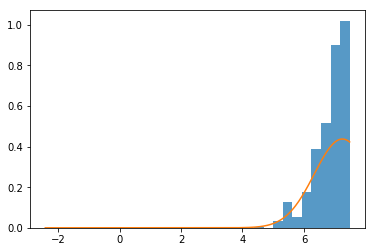

In [22]:
posterior_dist = model.posterior_distribution(num_traces=500, 
                                              inference_engine=pyprob.InferenceEngine.IMPORTANCE_SAMPLING_WITH_INFERENCE_NETWORK, 
                                              observation=[8,9])
n, bins, patches = plt.hist([float(posterior_dist.sample()) for i in range(1000)], normed=1, alpha=0.75)

x = np.linspace(posterior_dist.min,posterior_dist.max,400)
plt.plot(x, np.vectorize(correct_posterior)(x))

print('Mean:', posterior_dist.mean)
print('Standard deviation:', posterior_dist.stddev)